# Transfer Learning with Inceptionv3 and Chest X-Ray Data

In this notebook I will be demonstrating how transfer learning can be used to quickly retrain a model such as Inceptionv3 for a new task. The task in question will be binary classification of [chest x-ray images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) into the classes "has pneumonia" and "doesn't have pneumonia."

Since a user has uploaded the dataset to kaggle, I am writing this notebook in the [kaggle kernel environment](https://www.kaggle.com/kernels), which allows me to access the data easily. If you are viewing this notebook outside of kaggle, you can find the original at https://www.kaggle.com/rayheberer/inceptionv3-transfer-learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import keras

from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Data

Since the dataset is rather large, we won't be importing it. Instead, let's understand how the data directories are structured, and view some example images.

In [2]:
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray"))
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray/test"))
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray/train"))
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL")[0:4])
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA")[0:4])

['val', 'train', 'test', '.DS_Store']
['NORMAL', '.DS_Store', 'PNEUMONIA']
['NORMAL', '.DS_Store', 'PNEUMONIA']
['NORMAL2-IM-1232-0001.jpeg', 'NORMAL2-IM-0588-0001.jpeg', 'NORMAL2-IM-0667-0001.jpeg', 'NORMAL2-IM-0868-0001.jpeg']
['person63_bacteria_306.jpeg', 'person414_virus_845.jpeg', 'person419_virus_857.jpeg', 'person1216_virus_2062.jpeg']


It seems that the data is partitioned into training, validation, and testing sets which are stored in separate subdirectories. Within each dataset, images with and without pneumonia are again placed under separate subdirectories. When training the model, we will need to be careful to randomize the order it sees images from each class.

Let's take a look at a couple example images.

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
val_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/val/"
test_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/test/"

(1302, 927)


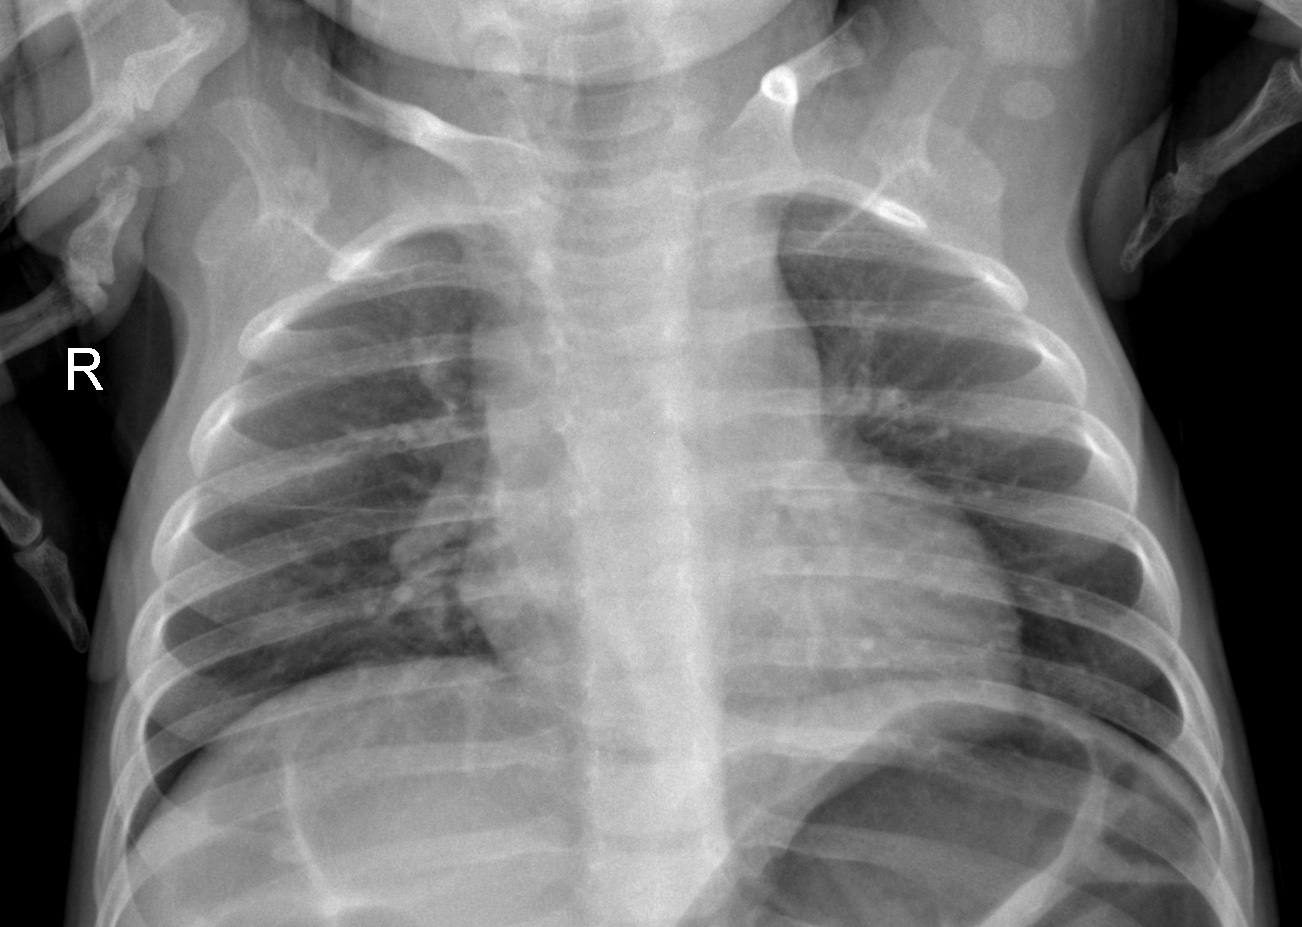

In [4]:
path1 = train_dir + "NORMAL/" + os.listdir(train_dir + "NORMAL/")[0]
im1 = Image.open(path1)
print(im1.size)
im1

(1048, 736)


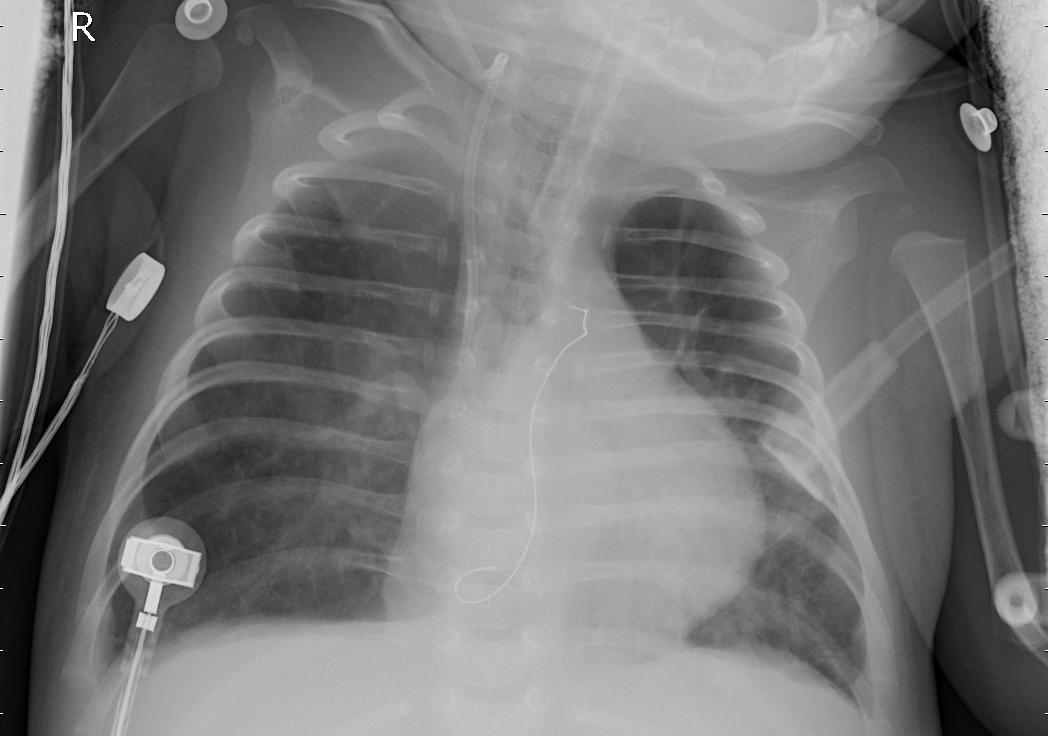

In [5]:
path2 = train_dir + "PNEUMONIA/" + os.listdir(train_dir + "PNEUMONIA/")[0]
im2 = Image.open(path2)
print(im2.size)
im2

As an untrained human, it is difficult to discern what makes these images different! Fortunately, we have machine learning to democratize the expert knowledge that went into labeling this dataset.

One more thing about the dataset to note for training is that the images have varying dimensions. They will need to resized in a preprocessing step during training into what the model expects.

## Model

Keras has [several pretrained models](https://keras.io/applications/) that can be imported. I will be using inceptionv3, with weights trained on the ImageNet dataset.

In [6]:
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Flatten()(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x) 
    
    model = keras.models.Model(inputs=base_model.input, outputs=predictions)

    return model

In [7]:
model = build_model()

87916544/87910968 [==============================] - 1s 0us/step


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training

In [9]:
gen_preprocessing = ImageDataGenerator(rescale=1/255)

train_generator = gen_preprocessing.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

test_generator = gen_preprocessing.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    class_mode="categorical",
    batch_size=16,
    shuffle=True
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
training = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=10
)

Epoch 1/10
82/82 [==============================] - 170s 2s/step - loss: 0.3569 - acc: 0.9001
Epoch 2/10
82/82 [==============================] - 162s 2s/step - loss: 0.2103 - acc: 0.9436
Epoch 3/10
82/82 [==============================] - 162s 2s/step - loss: 0.1211 - acc: 0.9625
Epoch 4/10
82/82 [==============================] - 162s 2s/step - loss: 0.1453 - acc: 0.9554
Epoch 5/10
82/82 [==============================] - 162s 2s/step - loss: 0.1630 - acc: 0.9566
Epoch 6/10
82/82 [==============================] - 162s 2s/step - loss: 0.1074 - acc: 0.9695
Epoch 7/10
82/82 [==============================] - 162s 2s/step - loss: 0.0969 - acc: 0.9727
Epoch 8/10
82/82 [==============================] - 162s 2s/step - loss: 0.0616 - acc: 0.9825
Epoch 9/10
82/82 [==============================] - 162s 2s/step - loss: 0.0656 - acc: 0.9796
Epoch 10/10
82/82 [==============================] - 162s 2s/step - loss: 0.0728 - acc: 0.9794


## Predictions

In [12]:
test_batch = test_generator.next()

In [13]:
# using argmin so that 0: normal

predictions = np.argmin(model.predict_on_batch(test_batch[0]), axis=1)
labels = np.argmin(test_batch[1], axis=1)

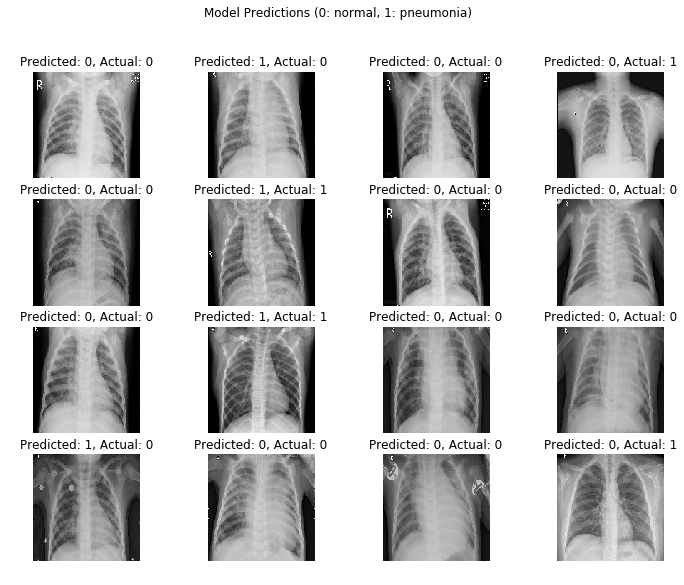

In [14]:
# see https://medium.com/the-semi-periodic-snippet/generating-matplotlib-subplots-programmatically-cc234629b648

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 9))
fig.subplots_adjust(hspace=0.2)
fig.suptitle("Model Predictions (0: normal, 1: pneumonia)")

for i, ax in enumerate(axes.flatten()):
    ax.imshow(test_batch[0][i])
    ax.axis("off")
    ax.set(title="Predicted: {}, Actual: {}".format(predictions[i], labels[i]))